## 정확도(Accuracy)

In [1]:
from sklearn.preprocessing import LabelEncoder
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

#### Sex 피처만으로 만든 모델을 정확도로 평가

In [2]:
# Sex 피처가 1(남성)이면 0(사망)으로 예측하는 Classifier

from sklearn.base import BaseEstimator
import numpy as np

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self,X):
        pred = np.zeros((X.shape[0],1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i]==1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본데이터를 재로딩, 데이터가공, 학습데이터/테스트데이터 분할
titanic_df = pd.read_csv('titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 Dummy Classifier를 이용, 학습/예측/평가 수행 
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도 : {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도 : 0.7877


#### 레이블값 예측을 하나로 떄려맞추는 모델

In [4]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClaasifier(BaseEstimator):
    def fit(self, X, y):
        pass

    # 입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트인 load_digits()를 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7이면 True, 이를 astypre(int)로 1로 변환, 7 아니면 False, 0으로 변환
y = (digits.target==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [5]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0,1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClaasifier()
fakeclf.fit(X_test, y_train)
fakepred=fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 : {:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0,1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 : 0.900


## 오차행렬

In [6]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

# TN : 틀렸다고 예측했는데 틀림 = 405
# FP : 맞았다고 예측했는데 틀림 = 0
# FN : 틀렸다고 예측했는데 맞음 = 45
# TP : 맞았다고 예측했는데 맞음 = 0

array([[405,   0],
       [ 45,   0]], dtype=int64)

## 정밀도(precision) / 재현율(recall)

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율:{2:.4f}'.format(accuracy, precision, recall))

In [8]:
# 로지스틱 회귀기반 타이타닉 생존자 예측모델에 대한 평가

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 재로딩, 데이터 가공, 학습데이터/테스트데이터 분할
titanic_df = pd.read_csv('titanic/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=15)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차 행렬
[[87 16]
 [21 55]]
정확도: 0.7933, 정밀도: 0.7746, 재현율:0.7237


C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [9]:
# 분류모델에서 각 레이블별 예측확률 구하기

# predict_proba() : 학습이 완료된 사이킷런 Classifier객체에서 호출, 각 레코드의 개별 클래스 예측확률 반환
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shape : {0}'. format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class중 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출 
: [[0.03794049 0.96205951]
 [0.25333361 0.74666639]
 [0.27470214 0.72529786]]
두 개의 class중 더 큰 확률을 클래스 값으로 예측 
 [[0.03794049 0.96205951 1.        ]
 [0.25333361 0.74666639 1.        ]
 [0.27470214 0.72529786 1.        ]]


In [10]:
# Binarizer 클래스 : 임곗값 조정

from sklearn.preprocessing import Binarizer

X = [[1,-1,2],
    [2,0,0],
    [0,1.1,1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [11]:
# Binarizer 클래스를 predict에 활용

from sklearn.preprocessing import Binarizer

# Bincarizer의 threshold 설정값 = 분류 결정 임곗값
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차 행렬
[[87 16]
 [21 55]]
정확도: 0.7933, 정밀도: 0.7746, 재현율:0.7237


In [12]:
# 임곗값 조정

custom_threshold = 0.4

pred_proba_1 = pred_proba[:,1].reshape(-1,1)
binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

# 분류 결정 임곗값은 positive 예측값을 결정하는 확률의 기준.
# 임곗값을 낮출수록 positive를 너그럼게 하기 때문에 positive로 예측할 확률 증가 -> 

오차 행렬
[[85 18]
 [16 60]]
정확도: 0.8101, 정밀도: 0.7692, 재현율:0.7895


In [31]:
# 임곗값을 0.05 씩 조정하면서 확인

thresholds = [0.40, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list 객체 내의 값을 차례로 iteration하면서 Evalutaion 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict, pred_proba_c1)
        
get_eval_by_threshold(y_test, pred_proba[:,-1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 정밀도: 0.6491, 재현율: 0.6852, F1:0.6667, AUC:0.8433
임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857, AUC:0.8433
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433
임곗값: 0.55
오차행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741, F1:0.6596, AUC:0.8433
임곗값: 0.6
오차행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185, F1:0.6154, AUC:0.8433


In [32]:
# precision_recall_curve() : 정밀도와 재현율 curve 반환
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 떄의 예측 확률 추출 (살아있을 확률)
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 떄의 예측확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 147건이므로 샘플로 10 건만 추출하된, 임곗값을 15step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index],2))

# 15step 단위로 추출된 임곗값에 따른 정밀도와 재현율 값
print('샘플 임곗값별 정밀도:', np.round(precisions[thr_index],3))
print('샘플 임곗값별 재현율:', np.round(recalls[thr_index],3))

반환된 분류 결정 임곗값 배열의 Shape: (124,)
샘플 추출을 위한 임곗값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120]
샘플용 10개의 임곗값: [0.11 0.14 0.21 0.29 0.35 0.46 0.66 0.78 0.9 ]
샘플 임곗값별 정밀도: [0.435 0.486 0.532 0.557 0.609 0.714 0.794 0.789 0.75 ]
샘플 임곗값별 재현율: [1.    0.981 0.926 0.815 0.722 0.648 0.5   0.278 0.056]


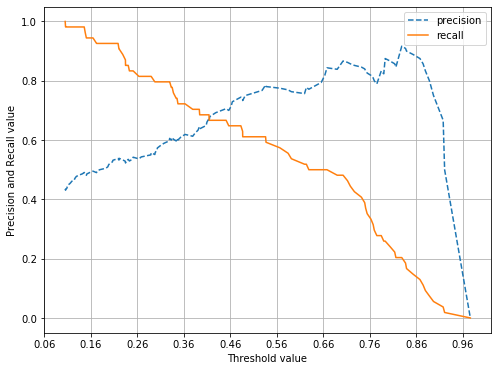

In [33]:
# precision_recall_curve 시각화

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축을 저임ㄹ도, 재현율 값으로 각각 Plot 수행. 저임ㄹ도는 점선으로 표시
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    
    # threshold 값 X축의 Scale을 0.1단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y출 label과 legend, 그리고 grid설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

## F1 스코어

In [34]:
# f1_score 모듈
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print('F1 스코어:{0:.4f}'.format(f1))

F1 스코어:0.6804


In [36]:
# 임곗값 변화 시 f1스코어의 변화

def get_clf_eval(y_test, pred, pred_proba):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    # F1스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    # f1 score print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1:{f1:.4f}')
          
thresholds = [0.4, 0.45, 0.5, 0.55, 0.6]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[80 20]
 [17 37]]
정확도: 0.7597, 정밀도: 0.6491, 재현율: 0.6852, F1:0.6667
임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804
임곗값: 0.55
오차행렬
[[91  9]
 [23 31]]
정확도: 0.7922, 정밀도: 0.7750, 재현율: 0.5741, F1:0.6596
임곗값: 0.6
오차행렬
[[91  9]
 [26 28]]
정확도: 0.7727, 정밀도: 0.7568, 재현율: 0.5185, F1:0.6154


## ROC curve, AUC score

In [37]:
# roc_curve 구하기
from sklearn.metrics import roc_curve

# 레이블 값이 1일떄의 예측확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임곗값 배열 로우가 47건, 샘플로 10건만 추출하되, 임곗값을 5step으로 추출
# thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0],5)
print('샘플 추출을 위한 임곗값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:',np.round(thresholds[thr_index],2))

# 5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index],3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index],3))

샘플 추출을 위한 임곗값 배열의 index 10개: [ 1  6 11 16 21 26 31 36 41 46]
샘플용 10개의 임곗값: [0.98 0.78 0.63 0.48 0.39 0.35 0.3  0.24 0.17 0.11]
샘플 임곗값별 FPR: [0.01 0.03 0.08 0.12 0.21 0.26 0.35 0.4  0.52 0.7 ]
샘플 임곗값별 TPR: [0.    0.278 0.5   0.648 0.685 0.741 0.796 0.852 0.926 1.   ]


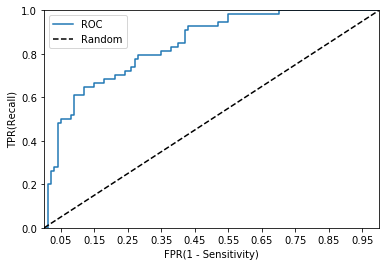

In [38]:
# roc curve 시각화
def roc_curve_plot(y_test, pred_proba_c1):
    # 임곗값에 따른 FPR, TPR값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X 축의 Scale을 0.1 단위로 변경, X, Y 축 명 설정 등
    start,end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0, 1); plt.ylim(0,1)
    plt.xlabel('FPR(1 - Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

In [39]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    # ROC-AUC print추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1:{f1:.4f}, AUC:{roc_auc:.4f}')

## 피마 인디언 당뇨병 예측

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head()

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [41]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [42]:
# 데이터를 피처와 레이블로 나눔
X = diabetes_data.iloc[:,:-1]
y = diabetes_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred= lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test,pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1:0.6392, AUC:0.7919


C:\Users\NK\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


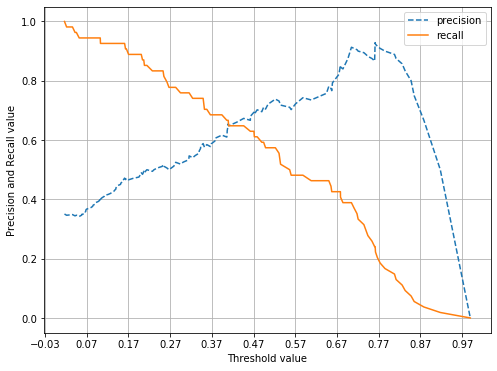

In [43]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

In [44]:
diabetes_data.describe()
# 혈청인슐린(insuline) 등의 최솟값이 0 인 것은 말이 안됨 

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


(array([  5.,   0.,   4.,  32., 156., 211., 163.,  95.,  56.,  46.]),
 array([  0. ,  19.9,  39.8,  59.7,  79.6,  99.5, 119.4, 139.3, 159.2,
        179.1, 199. ]),
 <a list of 10 Patch objects>)

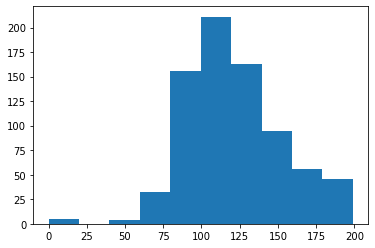

In [45]:
plt.hist(diabetes_data['Glucose'], bins=10)

In [46]:
# 0 값을 검사할 피처 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별 반복하며 데이터 값이 0인 데이터 건수를 추출, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print(f'{feature} 0 건수는 {zero_count}, 퍼센트는 {100*zero_count/total_count:.2f}%')

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [47]:
# zero_feature 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [48]:
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']

# StandardScaler 클래스를 이용, 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

#로 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred =lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433


In [49]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963, F1:0.6615, AUC:0.8433
임곗값: 0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778, F1:0.6774, AUC:0.8433
임곗값: 0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222, F1:0.6667, AUC:0.8433
임곗값: 0.39
오차행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037, F1:0.6667, AUC:0.8433
임곗값: 0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1:0.6792, AUC:0.8433
임곗값: 0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667, F1:0.6857, AUC:0.8433
임곗값: 0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931, AUC:0.8433
임곗값: 0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1:0.6804, AUC:0.8433


In [52]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1:0.6931, AUC:0.8433
